In [1]:
%matplotlib inline  
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from keras import metrics
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss
from sklearn.metrics import confusion_matrix

from numpy.random import seed
from tensorflow import set_random_seed
set_random_seed(2)
seed(1)

Using TensorFlow backend.


In [2]:
train_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")
train_labels = pd.read_csv("data/train_labels.csv",header=None).values.reshape(-1)
test_labels = pd.read_csv("data/test_labels.csv",header=None).values.reshape(-1)

In [3]:
train_data.head(5)

,AI552051.754,CYCLE.552051,FI552051_718,FIC552051_718,FQI552051.718,MODSTS.552051,PHASE.552051,PHTIME.552051,PI552051.641,PI552051.642,...,SIC552051.801_CO_Bad Input,SIC552051.801_CO_I/O Timeout,PI552051.646_Bad Input,PI552051.646_I/O Timeout,PHTIME.552051_Bad Input,PHTIME.552051_I/O Timeout,SIC552051.801_Bad Input,SIC552051.801_I/O Timeout,PI552051.641_Bad Input,PI552051.641_I/O Timeout
0,0.085130,0.0,0.012009,12.009277,208.416672,8.0,21.0,2.698205,0.042778,0.067184,...,0,0,0,0,0,0,0,0,0,0
1,0.085414,0.0,0.012009,12.009277,208.454514,8.0,23.0,2.698218,0.042875,0.067232,...,0,0,0,0,0,0,0,0,0,0
2,0.085697,0.0,0.012009,12.009277,208.492371,8.0,23.0,2.698231,0.041802,0.067184,...,0,0,0,0,0,0,0,0,0,0
3,0.085980,0.0,0.012009,12.009277,208.530212,8.0,23.0,2.698245,0.042720,0.067184,...,0,0,0,0,0,0,0,0,0,0
4,0.086263,0.0,0.012009,12.009277,208.568069,8.0,23.0,2.698258,0.041992,0.067940,...,0,0,0,0,0,0,0,0,0,0


In [4]:
cat_cols = [k for k in list(train_data.columns) if train_data[k].dtype != "float64"]
num_cols = list(set(list(train_data.columns))-set(cat_cols))


In [5]:
categorical_data = train_data[cat_cols]
numeric_data = train_data[num_cols]
print(categorical_data.shape,numeric_data.shape)

(65809, 132) (65809, 23)


In [6]:
# Prepare a forcast model for vaiable

split = int(0.2*len(train_data))

# make univariate to processible dimensions
def process_sequence(seq,time_steps):
    data = []
    value = []
    i = time_steps
    while i < len(seq):
        data.append(seq[i-time_steps:i])
        value.append(seq[i])
        i+=1
    return np.asarray(data),np.asarray(value)


In [10]:
from keras.optimizers import SGD
from keras.models import load_model
from keras.losses import mean_squared_error,mean_absolute_error, logcosh, categorical_crossentropy, sparse_categorical_crossentropy
from keras.callbacks import TerminateOnNaN, LearningRateScheduler, EarlyStopping

cb1 = EarlyStopping(monitor='loss', min_delta=0.0001, patience=3, verbose=0, mode='auto', restore_best_weights=False)
cb2 = TerminateOnNaN()
cb = [cb1,cb2]


def plot_preds(tst_y,yhat):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(len(tst_y)),tst_y,"r--")
    plt.plot(np.arange(len(yhat)),yhat,"b--")
    plt.savefig("img/"+col+"ts_6.png")
    plt.show()

    
n_features = 1 # it is a univariate data
n_steps = 6  # 60 mins gives 1 hr

optim = SGD(lr=0.01, momentum=0.0, nesterov=False)
prediction_store = {}
def columnwise_forecast(col):
    
    X,y = process_sequence(train_data[col],n_steps)
    print(X.shape,y.shape)
    n_samples = len(X)
    X = X.reshape(n_samples,n_steps,n_features)
    print(X.shape,y.shape)
    print("Data processed to feed shape ")

    # LSTM Model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss=logcosh)
    
    model.fit(X, y, epochs=200, verbose=1,callbacks=cb)
    tst_X,tst_y = process_sequence(test_data[col],n_steps)
    tst_X = tst_X.reshape(tst_X.shape[0],n_steps,n_features)

    yhat = model.predict(tst_X, verbose=0)
    print("Saving model")
    model.save("models/"+col.replace(".","_")+"_predictor_model.h5")
    del model
    plot_preds(tst_y,yhat)
    
    prediction_store[col] = (tst_y,yhat)


(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 19s 282us/step - loss: 4.1555e-05
Epoch 2/200
65803/65803 [==============================] - 17s 264us/step - loss: 2.0891e-05
Epoch 3/200
65803/65803 [==============================] - 18s 271us/step - loss: 2.0569e-05
Epoch 4/200
65803/65803 [==============================] - 18s 273us/step - loss: 2.0306e-05
Saving model


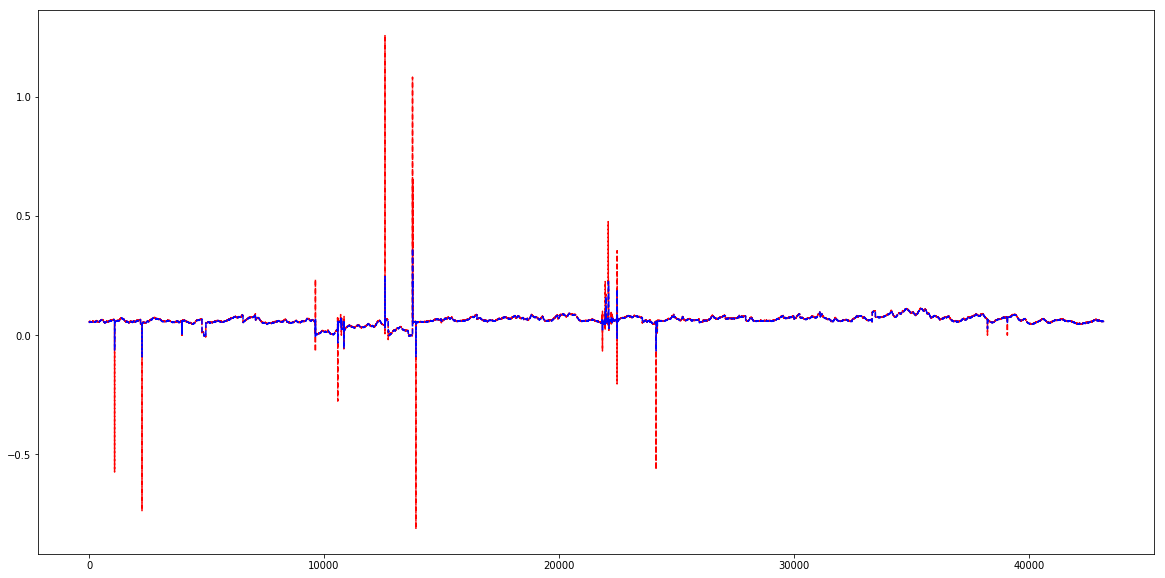

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 17s 257us/step - loss: 3.4886e-06
Epoch 2/200
65803/65803 [==============================] - 18s 266us/step - loss: 1.1913e-06
Epoch 3/200
65803/65803 [==============================] - 17s 257us/step - loss: 9.4119e-07
Epoch 4/200
65803/65803 [==============================] - 17s 259us/step - loss: 8.1855e-07
Saving model


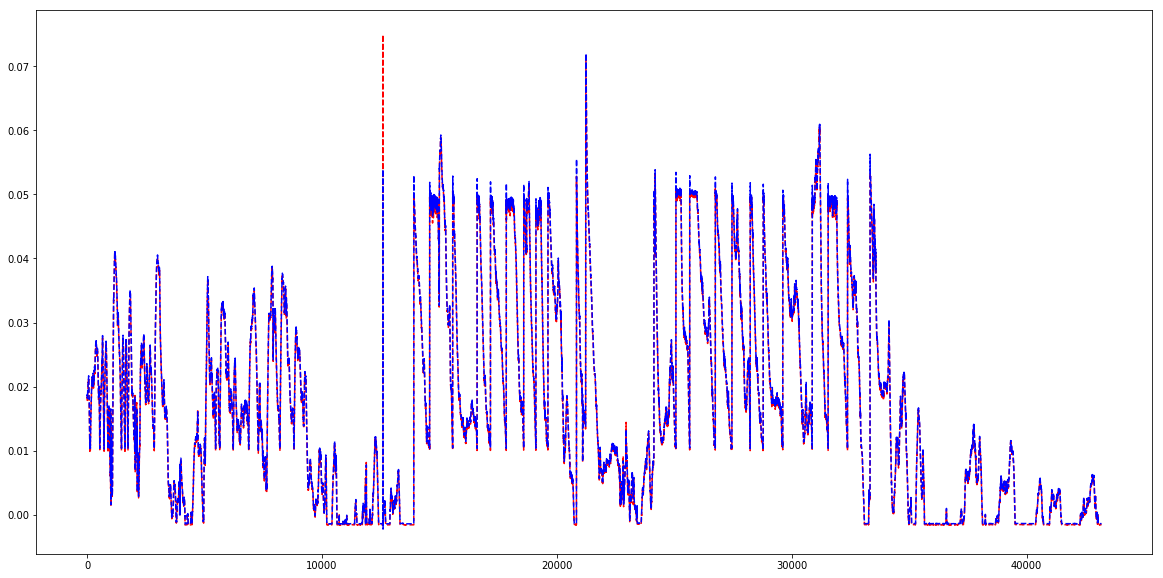

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 18s 279us/step - loss: 0.0200
Epoch 2/200
65803/65803 [==============================] - 16s 247us/step - loss: 0.0139
Epoch 3/200
65803/65803 [==============================] - 16s 248us/step - loss: 0.0139
Epoch 4/200
65803/65803 [==============================] - 16s 251us/step - loss: 0.0137
Epoch 5/200
65803/65803 [==============================] - 15s 231us/step - loss: 0.0137
Epoch 6/200
65803/65803 [==============================] - 18s 279us/step - loss: 0.0135
Epoch 7/200
65803/65803 [==============================] - 17s 255us/step - loss: 0.0135
Epoch 8/200
65803/65803 [==============================] - 18s 280us/step - loss: 0.0134
Epoch 9/200
65803/65803 [==============================] - 18s 279us/step - loss: 0.0134
Epoch 10/200
65803/65803 [==============================] - 18s 272us/step - loss: 0.0134
Epoch 11/200
65803/65803 [==========

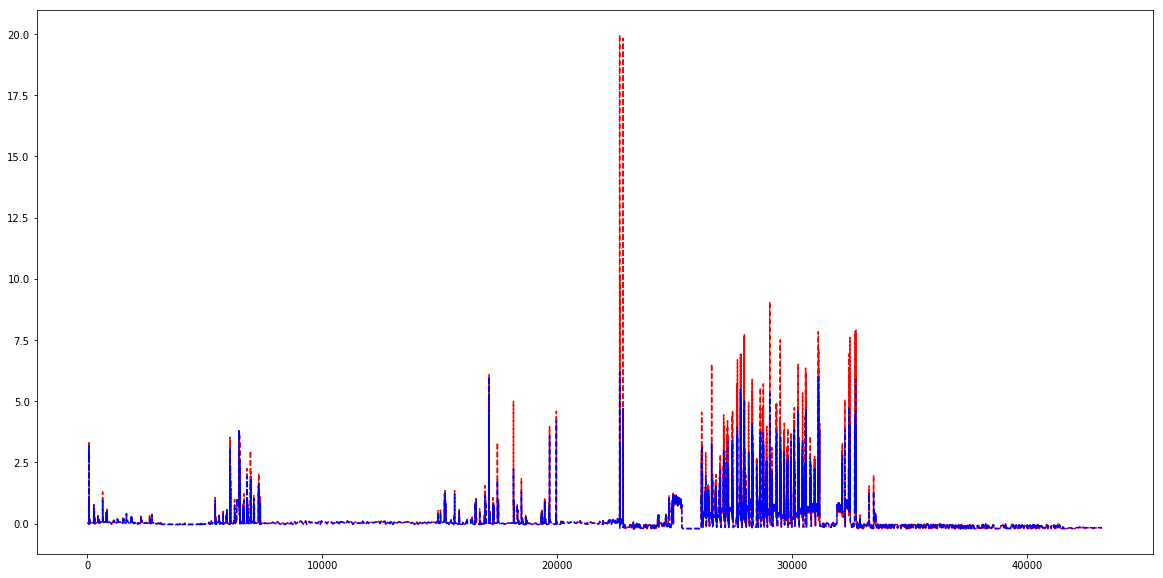

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 19s 294us/step - loss: 7.4594e-07
Epoch 2/200
65803/65803 [==============================] - 18s 269us/step - loss: 2.6727e-07
Epoch 3/200
65803/65803 [==============================] - 16s 242us/step - loss: 2.6067e-07
Epoch 4/200
65803/65803 [==============================] - 18s 271us/step - loss: 2.6667e-07
Saving model


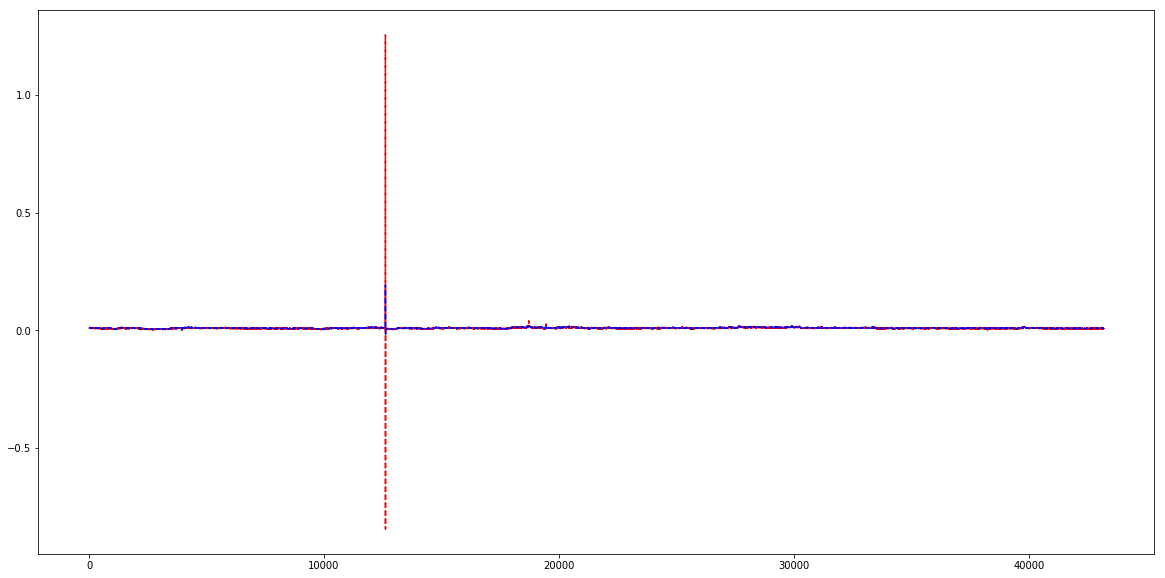

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 18s 275us/step - loss: 11.3340
Epoch 2/200
65803/65803 [==============================] - 15s 232us/step - loss: 8.3597
Epoch 3/200
65803/65803 [==============================] - 15s 225us/step - loss: 6.5779
Epoch 4/200
65803/65803 [==============================] - 16s 239us/step - loss: 5.6661
Epoch 5/200
65803/65803 [==============================] - 17s 256us/step - loss: 5.4648
Epoch 6/200
65803/65803 [==============================] - 19s 282us/step - loss: 5.4367
Epoch 7/200
65803/65803 [==============================] - 18s 270us/step - loss: 5.3529
Epoch 8/200
65803/65803 [==============================] - 17s 262us/step - loss: 5.3409
Epoch 9/200
65803/65803 [==============================] - 19s 288us/step - loss: 5.2999
Epoch 10/200
65803/65803 [==============================] - 18s 272us/step - loss: 5.3106
Epoch 11/200
65803/65803 [=========

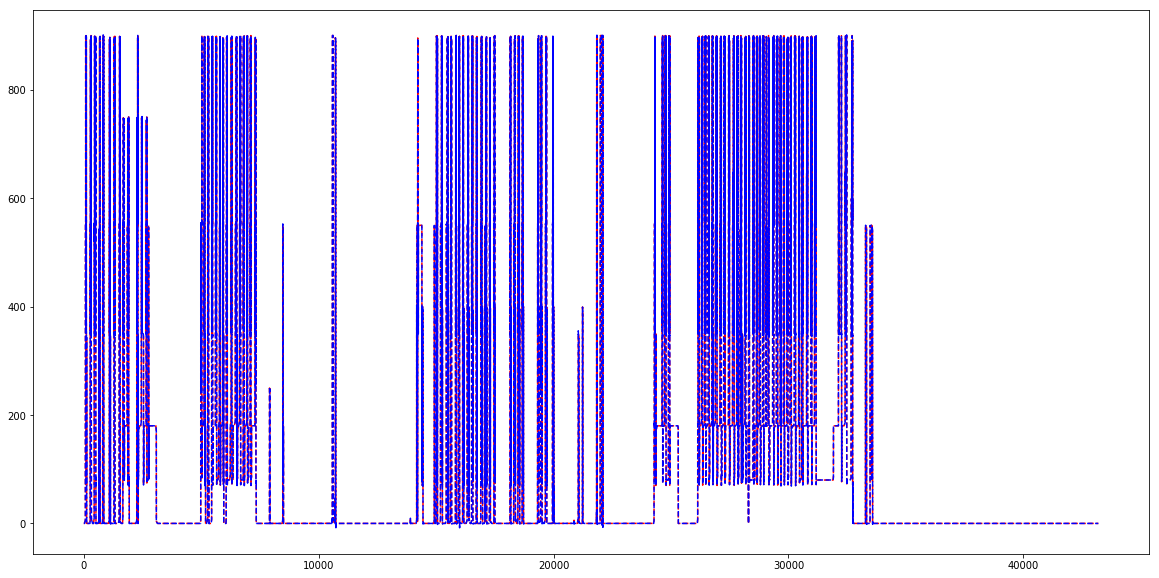

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 18s 270us/step - loss: 11.0824
Epoch 2/200
65803/65803 [==============================] - 16s 246us/step - loss: 8.3796
Epoch 3/200
65803/65803 [==============================] - 19s 292us/step - loss: 6.5477
Epoch 4/200
65803/65803 [==============================] - 19s 293us/step - loss: 6.0614
Epoch 5/200
65803/65803 [==============================] - 20s 302us/step - loss: 5.9998
Epoch 6/200
65803/65803 [==============================] - 19s 292us/step - loss: 5.9837
Epoch 7/200
65803/65803 [==============================] - 21s 312us/step - loss: 5.9077
Epoch 8/200
65803/65803 [==============================] - 20s 302us/step - loss: 5.8563
Epoch 9/200
65803/65803 [==============================] - 18s 277us/step - loss: 5.8594
Epoch 10/200
65803/65803 [==============================] - 19s 283us/step - loss: 5.8138
Epoch 11/200
65803/65803 [=========

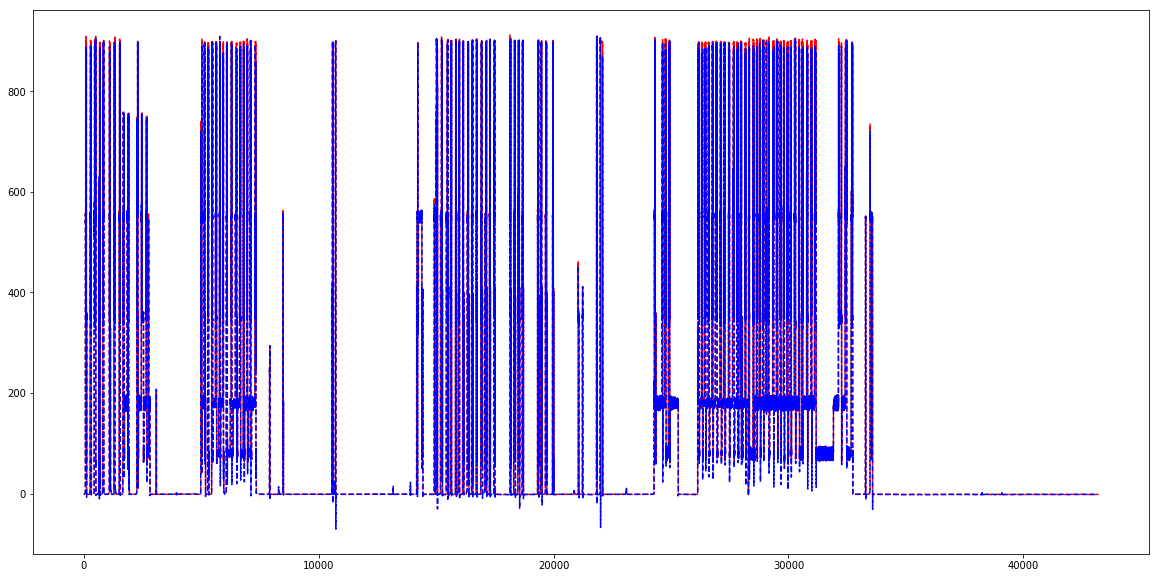

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 20s 310us/step - loss: 0.2585
Epoch 2/200
65803/65803 [==============================] - 19s 292us/step - loss: 0.0075
Epoch 3/200
65803/65803 [==============================] - 17s 259us/step - loss: 0.0069
Epoch 4/200
65803/65803 [==============================] - 20s 302us/step - loss: 0.0062
Epoch 5/200
65803/65803 [==============================] - 20s 299us/step - loss: 0.0061
Epoch 6/200
65803/65803 [==============================] - 17s 263us/step - loss: 0.0060
Epoch 7/200
65803/65803 [==============================] - 16s 246us/step - loss: 0.0058
Epoch 8/200
65803/65803 [==============================] - 19s 283us/step - loss: 0.0061
Epoch 9/200
65803/65803 [==============================] - 23s 343us/step - loss: 0.0055
Epoch 10/200
65803/65803 [==============================] - 17s 266us/step - loss: 0.0056
Epoch 11/200
65803/65803 [==========

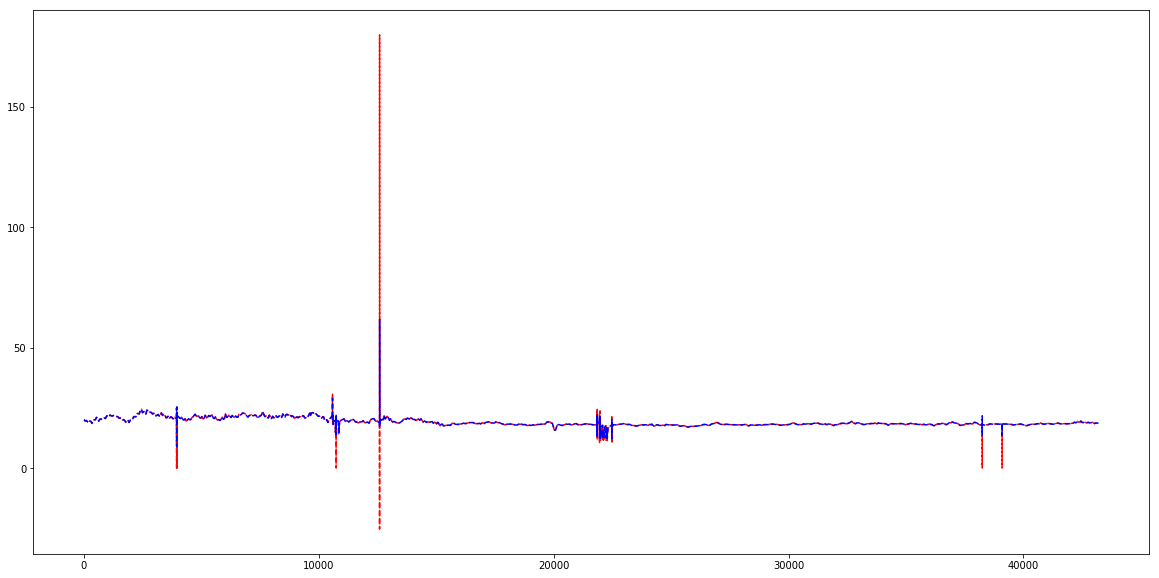

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 17s 253us/step - loss: 3.4320
Epoch 2/200
65803/65803 [==============================] - 18s 276us/step - loss: 2.3556
Epoch 3/200
65803/65803 [==============================] - 16s 249us/step - loss: 2.2910
Epoch 4/200
65803/65803 [==============================] - 18s 277us/step - loss: 2.1790
Epoch 5/200
65803/65803 [==============================] - 20s 298us/step - loss: 2.0135
Epoch 6/200
65803/65803 [==============================] - 18s 267us/step - loss: 2.1590
Epoch 7/200
65803/65803 [==============================] - 19s 285us/step - loss: 1.9840
Epoch 8/200
65803/65803 [==============================] - 16s 241us/step - loss: 1.9075
Epoch 9/200
65803/65803 [==============================] - 17s 265us/step - loss: 1.8855
Epoch 10/200
65803/65803 [==============================] - 17s 253us/step - loss: 1.8936
Epoch 11/200
65803/65803 [==========

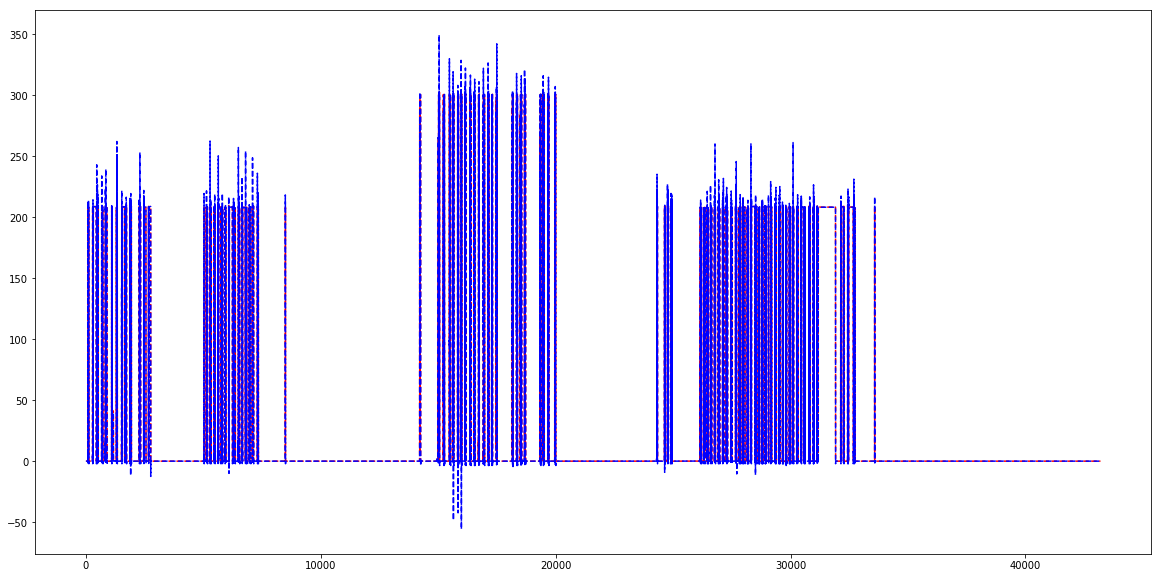

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 15s 232us/step - loss: 12.8995
Epoch 2/200
65803/65803 [==============================] - 19s 289us/step - loss: 8.3768
Epoch 3/200
65803/65803 [==============================] - 21s 315us/step - loss: 7.5508
Epoch 4/200
65803/65803 [==============================] - 21s 318us/step - loss: 7.7277
Epoch 5/200
65803/65803 [==============================] - 18s 276us/step - loss: 7.4665
Epoch 6/200
65803/65803 [==============================] - 18s 280us/step - loss: 7.3405
Epoch 7/200
65803/65803 [==============================] - 18s 276us/step - loss: 7.2475
Epoch 8/200
65803/65803 [==============================] - 20s 302us/step - loss: 7.1962
Epoch 9/200
65803/65803 [==============================] - 21s 321us/step - loss: 7.1748
Epoch 10/200
65803/65803 [==============================] - 13s 195us/step - loss: 7.1548
Epoch 11/200
65803/65803 [=========

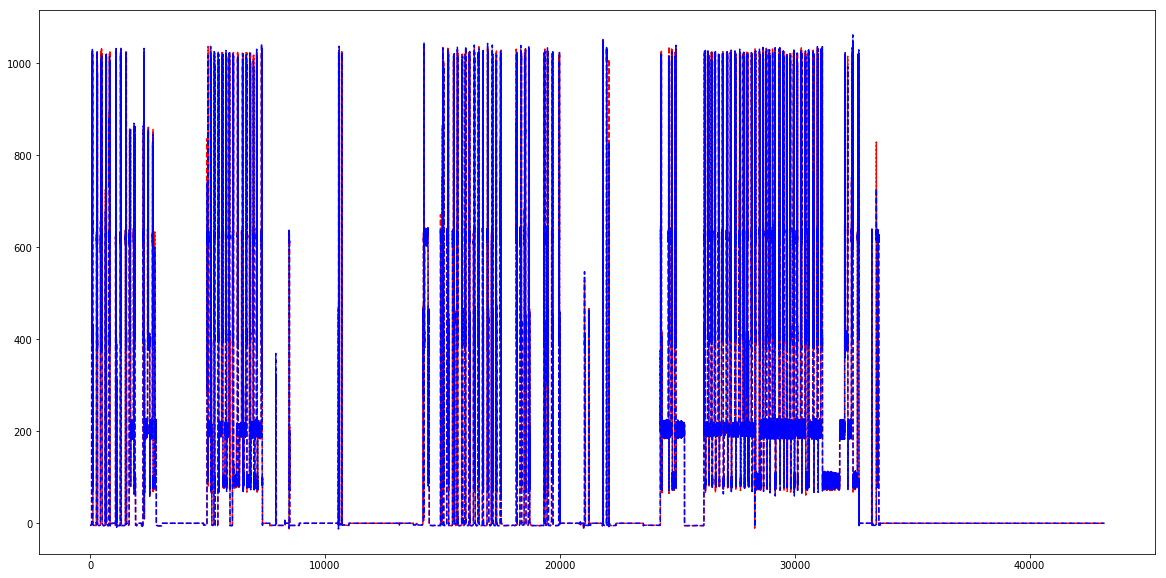

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 18s 270us/step - loss: 10.1483
Epoch 2/200
65803/65803 [==============================] - 19s 282us/step - loss: 7.5061
Epoch 3/200
65803/65803 [==============================] - 20s 302us/step - loss: 6.9764
Epoch 4/200
65803/65803 [==============================] - 18s 275us/step - loss: 6.8215
Epoch 5/200
65803/65803 [==============================] - 17s 260us/step - loss: 6.5067
Epoch 6/200
65803/65803 [==============================] - 19s 289us/step - loss: 6.0409
Epoch 7/200
65803/65803 [==============================] - 16s 247us/step - loss: 6.0314
Epoch 8/200
65803/65803 [==============================] - 19s 292us/step - loss: 5.9136
Epoch 9/200
65803/65803 [==============================] - 18s 275us/step - loss: 5.8935
Epoch 10/200
65803/65803 [==============================] - 21s 318us/step - loss: 5.8725
Epoch 11/200
65803/65803 [=========

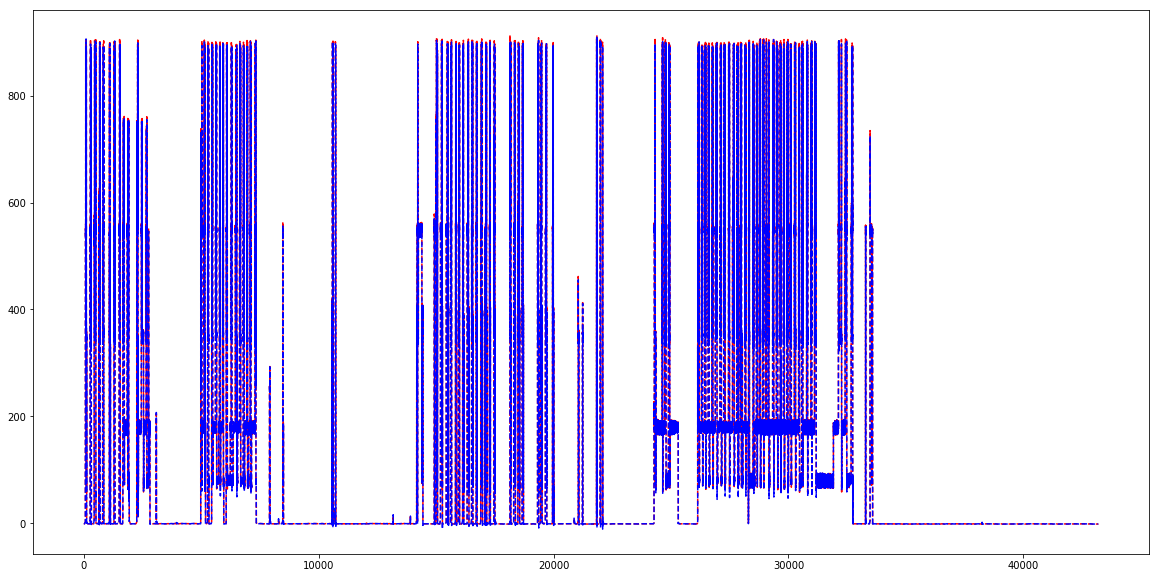

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 19s 291us/step - loss: 9.3808
Epoch 2/200
65803/65803 [==============================] - 20s 302us/step - loss: 9.0178
Epoch 3/200
65803/65803 [==============================] - 19s 292us/step - loss: 8.8087
Epoch 4/200
65803/65803 [==============================] - 18s 276us/step - loss: 8.8685
Epoch 5/200
65803/65803 [==============================] - 20s 297us/step - loss: 8.8159
Epoch 6/200
65803/65803 [==============================] - 16s 245us/step - loss: 8.6439
Epoch 7/200
65803/65803 [==============================] - 15s 226us/step - loss: 8.5739
Epoch 8/200
65803/65803 [==============================] - 13s 197us/step - loss: 8.4535
Epoch 9/200
65803/65803 [==============================] - 19s 292us/step - loss: 8.4542
Epoch 10/200
65803/65803 [==============================] - 19s 296us/step - loss: 8.3841
Epoch 11/200
65803/65803 [==========

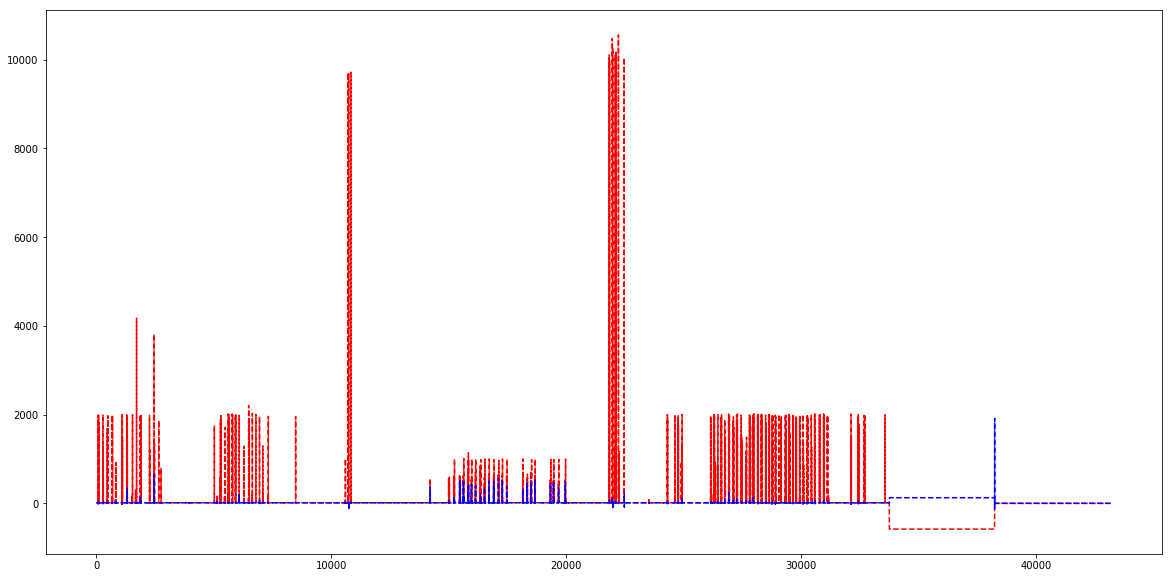

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 14s 210us/step - loss: 0.0445
Epoch 2/200
65803/65803 [==============================] - 16s 238us/step - loss: 0.0035
Epoch 3/200
65803/65803 [==============================] - 20s 304us/step - loss: 0.0029
Epoch 4/200
65803/65803 [==============================] - 18s 274us/step - loss: 0.0024
Epoch 5/200
65803/65803 [==============================] - 19s 294us/step - loss: 0.0021
Epoch 6/200
65803/65803 [==============================] - 17s 262us/step - loss: 0.0019
Epoch 7/200
65803/65803 [==============================] - 18s 270us/step - loss: 0.0019
Epoch 8/200
65803/65803 [==============================] - 20s 299us/step - loss: 0.0018
Epoch 9/200
65803/65803 [==============================] - 15s 224us/step - loss: 0.0019
Saving model


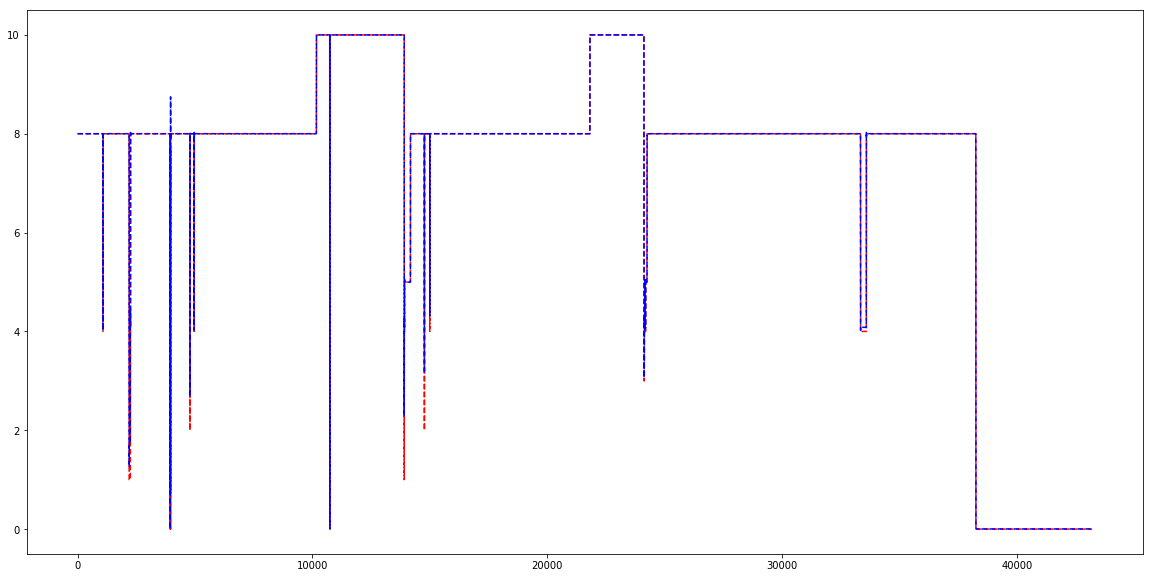

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 15s 232us/step - loss: 0.0734
Epoch 2/200
65803/65803 [==============================] - 16s 248us/step - loss: 0.0183
Epoch 3/200
65803/65803 [==============================] - 19s 285us/step - loss: 0.0159
Epoch 4/200
65803/65803 [==============================] - 21s 323us/step - loss: 0.0149
Epoch 5/200
65803/65803 [==============================] - 20s 307us/step - loss: 0.0149
Epoch 6/200
65803/65803 [==============================] - 17s 259us/step - loss: 0.0144
Epoch 7/200
65803/65803 [==============================] - 19s 286us/step - loss: 0.0143
Epoch 8/200
65803/65803 [==============================] - 20s 299us/step - loss: 0.0142
Epoch 9/200
65803/65803 [==============================] - 18s 269us/step - loss: 0.0140
Epoch 10/200
65803/65803 [==============================] - 19s 288us/step - loss: 0.0141
Epoch 11/200
65803/65803 [==========

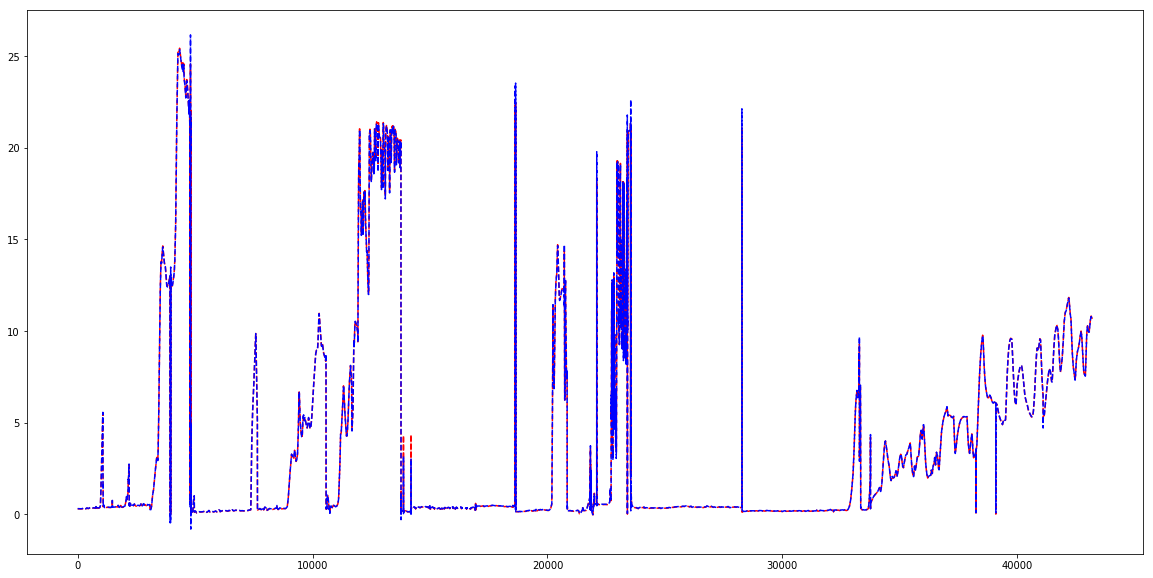

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 14s 219us/step - loss: 7.3583
Epoch 2/200
65803/65803 [==============================] - 18s 274us/step - loss: 2.0912
Epoch 3/200
65803/65803 [==============================] - 20s 307us/step - loss: 4.4055
Epoch 4/200
65803/65803 [==============================] - 18s 274us/step - loss: 3.4247
Epoch 5/200
65803/65803 [==============================] - 19s 294us/step - loss: 2.6330
Saving model


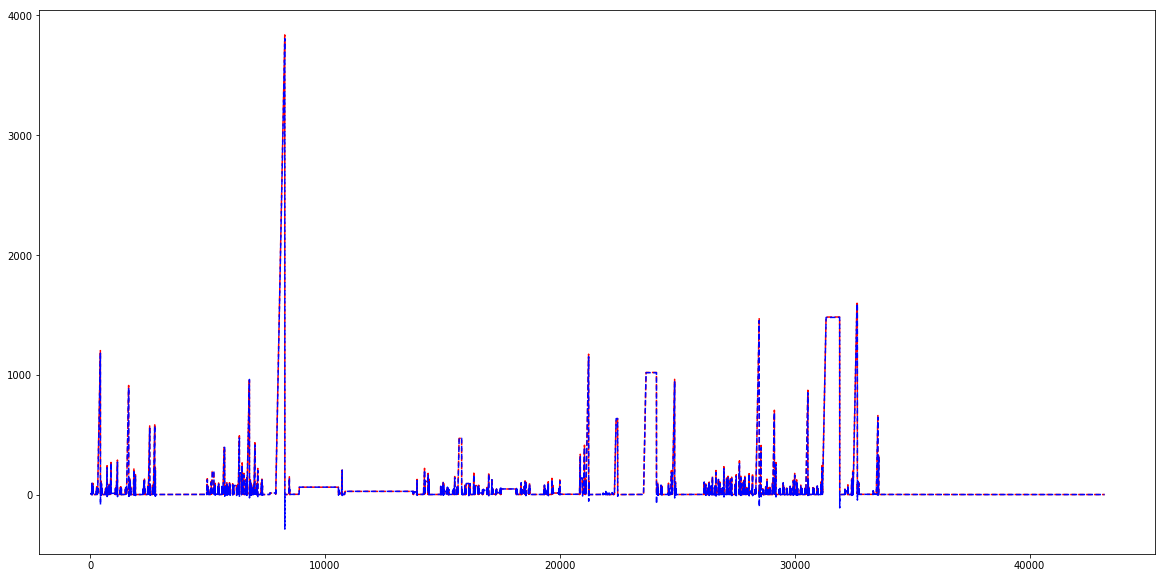

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 21s 325us/step - loss: 6.1773e-06
Epoch 2/200
65803/65803 [==============================] - 21s 319us/step - loss: 3.6504e-06
Epoch 3/200
65803/65803 [==============================] - 19s 285us/step - loss: 3.2466e-06
Epoch 4/200
65803/65803 [==============================] - 21s 321us/step - loss: 3.0233e-06
Saving model


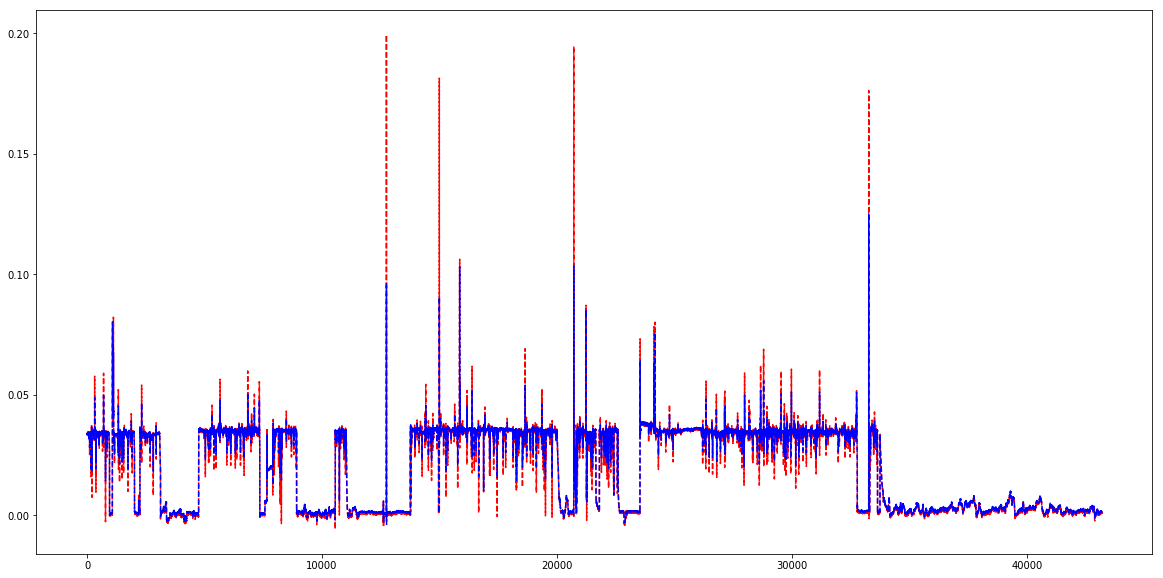

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 15s 231us/step - loss: 2.3796
Epoch 2/200
65803/65803 [==============================] - 20s 303us/step - loss: 0.4489
Epoch 3/200
65803/65803 [==============================] - 18s 270us/step - loss: 0.4255
Epoch 4/200
65803/65803 [==============================] - 19s 287us/step - loss: 0.4280
Epoch 5/200
65803/65803 [==============================] - 20s 305us/step - loss: 0.4519
Epoch 6/200
65803/65803 [==============================] - 19s 282us/step - loss: 0.4125
Epoch 7/200
65803/65803 [==============================] - 21s 315us/step - loss: 0.4049
Epoch 8/200
65803/65803 [==============================] - 19s 288us/step - loss: 0.4169
Epoch 9/200
65803/65803 [==============================] - 18s 276us/step - loss: 0.4014
Epoch 10/200
65803/65803 [==============================] - 20s 305us/step - loss: 0.4025
Epoch 11/200
65803/65803 [==========

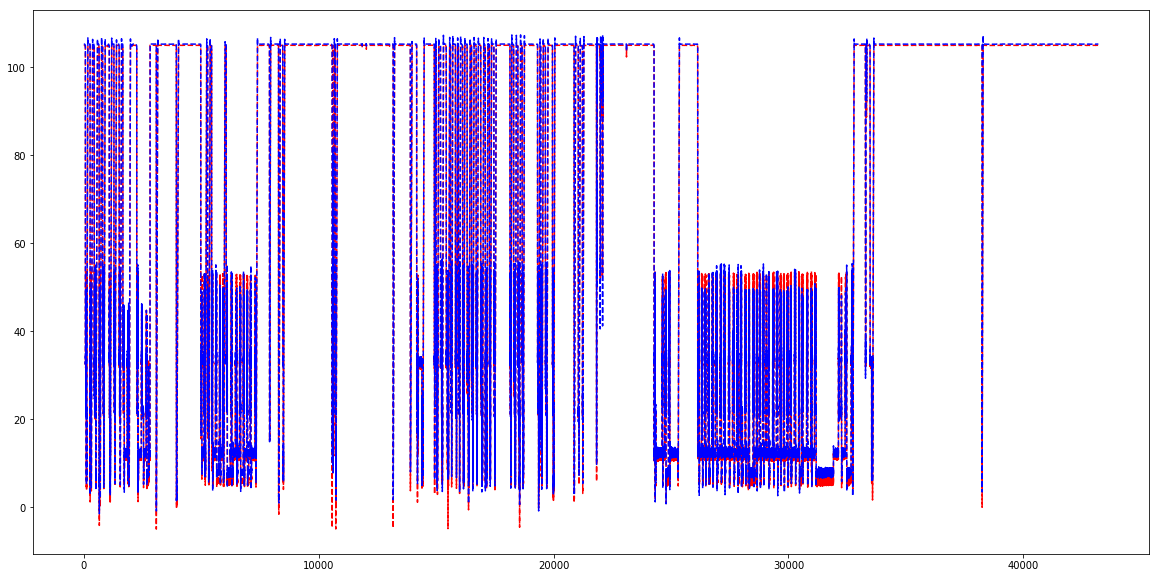

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 17s 255us/step - loss: 11733.6097
Epoch 2/200
65803/65803 [==============================] - 21s 315us/step - loss: 1525.8851
Epoch 3/200
65803/65803 [==============================] - 20s 311us/step - loss: 1476.5070
Epoch 4/200
65803/65803 [==============================] - 19s 285us/step - loss: 1628.8919
Epoch 5/200
65803/65803 [==============================] - 21s 315us/step - loss: 1487.0779
Epoch 6/200
65803/65803 [==============================] - 21s 316us/step - loss: 1358.4313
Epoch 7/200
65803/65803 [==============================] - 14s 217us/step - loss: 1924.3639
Epoch 8/200
65803/65803 [==============================] - 18s 267us/step - loss: 1644.9213
Epoch 9/200
65803/65803 [==============================] - 19s 286us/step - loss: 1351.9097
Epoch 10/200
65803/65803 [==============================] - 15s 226us/step - loss: 1766.1654
Epoch

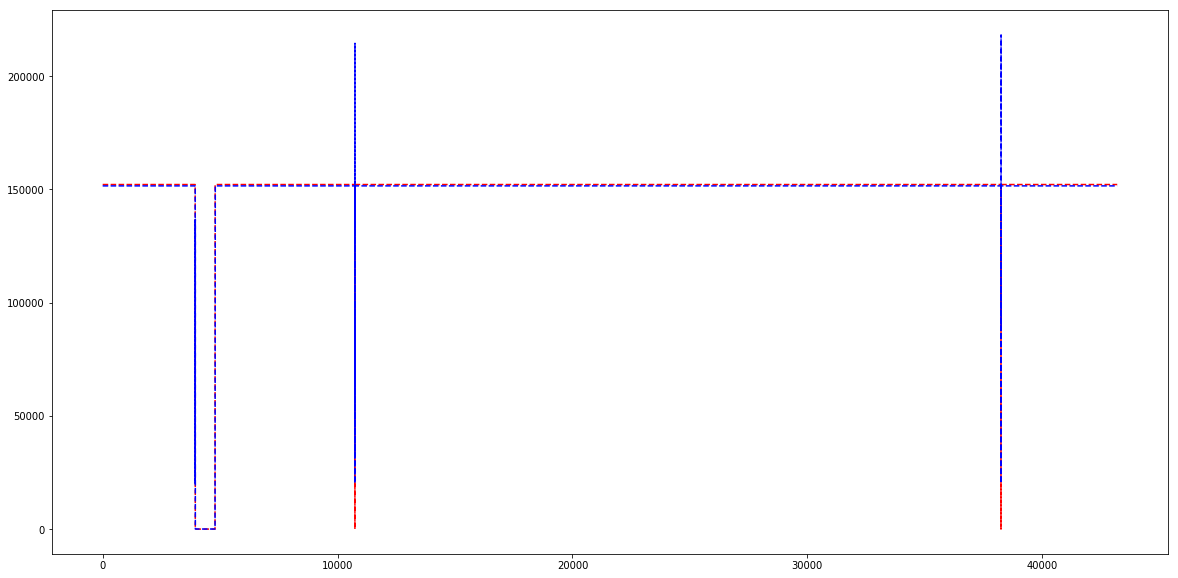

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 25s 380us/step - loss: 1748984325338734.0000
Epoch 2/200
65803/65803 [==============================] - 20s 311us/step - loss: 1412774868661325.7500
Epoch 3/200
65803/65803 [==============================] - 15s 233us/step - loss: 1453597332688781.0000
Epoch 4/200
65803/65803 [==============================] - 17s 266us/step - loss: 1729342818849286.0000
Epoch 5/200
65803/65803 [==============================] - 19s 284us/step - loss: 1498112424269463.5000
Saving model


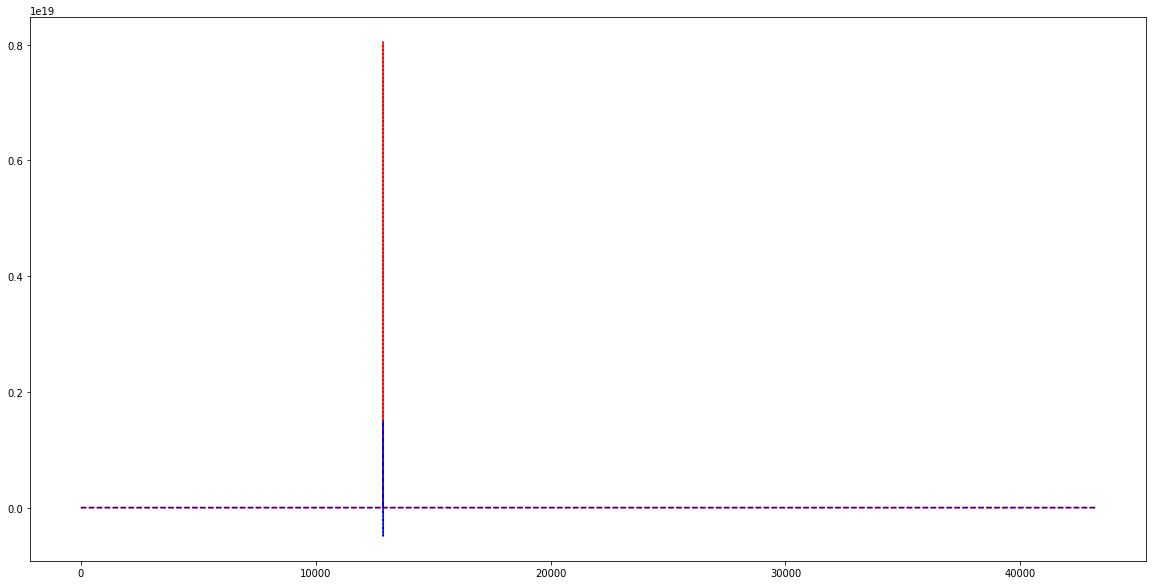

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 19s 289us/step - loss: 0.0039
Epoch 2/200
65803/65803 [==============================] - 20s 305us/step - loss: 0.0030
Epoch 3/200
65803/65803 [==============================] - 18s 278us/step - loss: 0.0030
Epoch 4/200
65803/65803 [==============================] - 21s 317us/step - loss: 0.0030
Epoch 5/200
65803/65803 [==============================] - 17s 262us/step - loss: 0.0030
Saving model


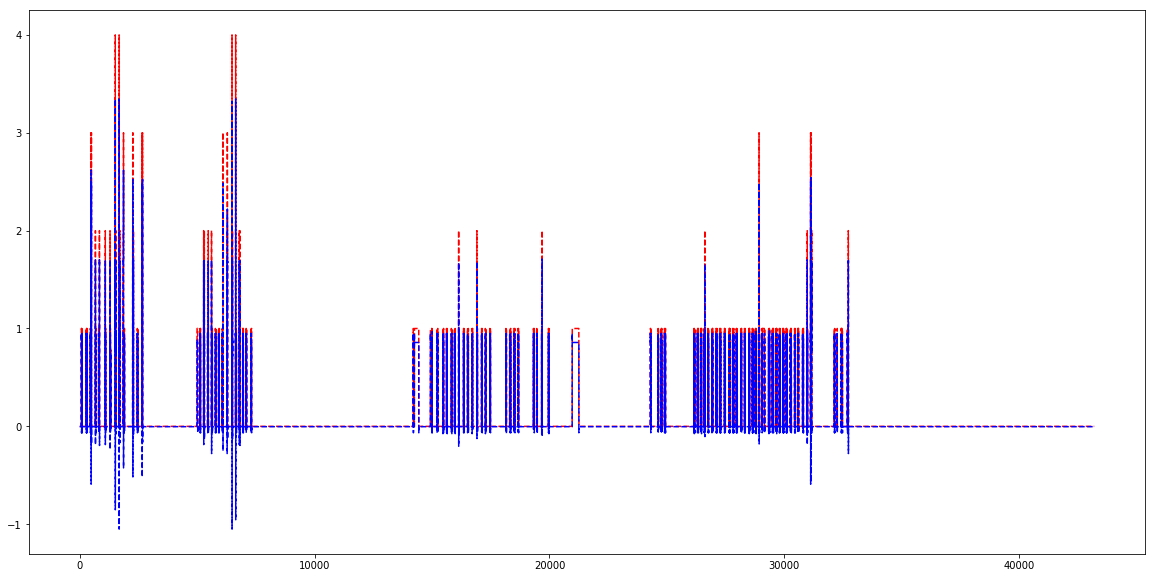

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 15s 235us/step - loss: 4.4993
Epoch 2/200
65803/65803 [==============================] - 19s 287us/step - loss: 0.3956
Epoch 3/200
65803/65803 [==============================] - 22s 341us/step - loss: 0.3690
Epoch 4/200
65803/65803 [==============================] - 20s 302us/step - loss: 0.3703
Epoch 5/200
65803/65803 [==============================] - 19s 288us/step - loss: 0.3454
Epoch 6/200
65803/65803 [==============================] - 19s 290us/step - loss: 0.3128
Epoch 7/200
65803/65803 [==============================] - 18s 276us/step - loss: 0.3036
Epoch 8/200
65803/65803 [==============================] - 17s 262us/step - loss: 0.3107
Epoch 9/200
65803/65803 [==============================] - 14s 211us/step - loss: 0.2898
Epoch 10/200
65803/65803 [==============================] - 19s 294us/step - loss: 0.2686
Epoch 11/200
65803/65803 [==========

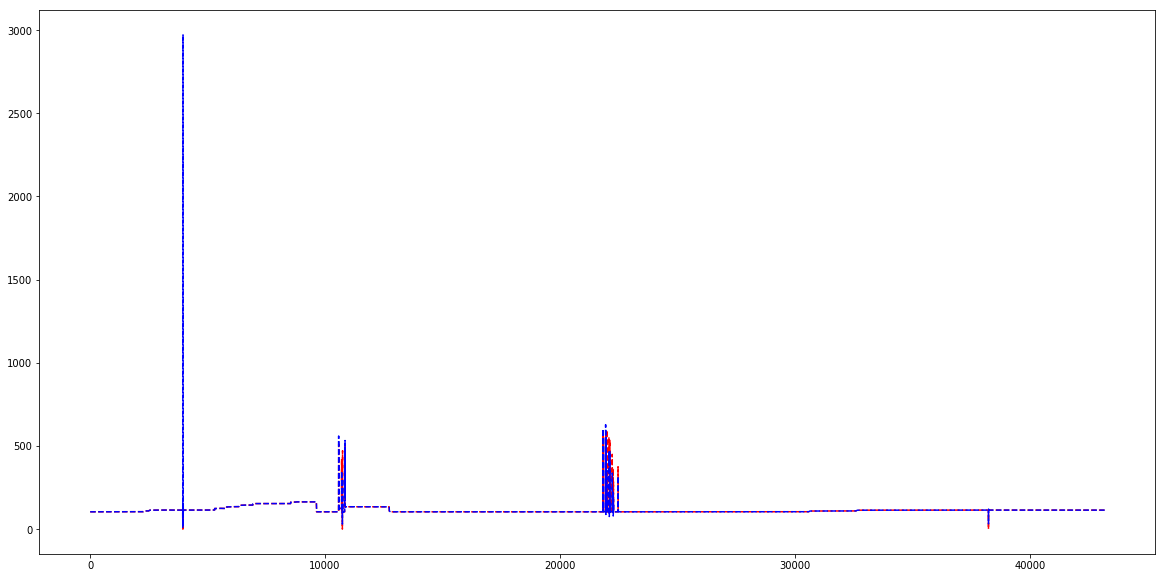

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 24s 366us/step - loss: 0.3057
Epoch 2/200
65803/65803 [==============================] - 18s 266us/step - loss: 0.0845
Epoch 3/200
65803/65803 [==============================] - 22s 338us/step - loss: 0.0821
Epoch 4/200
65803/65803 [==============================] - 19s 295us/step - loss: 0.0816
Epoch 5/200
65803/65803 [==============================] - 17s 265us/step - loss: 0.0814
Epoch 6/200
65803/65803 [==============================] - 15s 222us/step - loss: 0.0808
Epoch 7/200
65803/65803 [==============================] - 16s 247us/step - loss: 0.0804
Epoch 8/200
65803/65803 [==============================] - 17s 258us/step - loss: 0.0800
Epoch 9/200
65803/65803 [==============================] - 18s 268us/step - loss: 0.0796
Epoch 10/200
65803/65803 [==============================] - 13s 197us/step - loss: 0.0794
Epoch 11/200
65803/65803 [==========

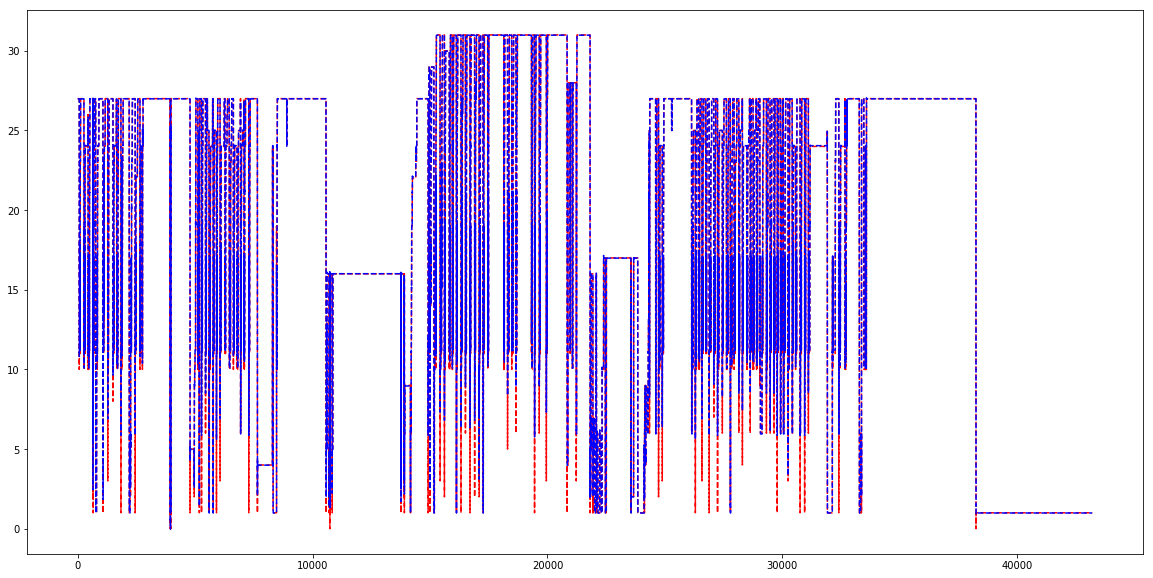

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 17s 261us/step - loss: 0.0041
Epoch 2/200
65803/65803 [==============================] - 20s 310us/step - loss: 0.0040
Epoch 3/200
65803/65803 [==============================] - 22s 329us/step - loss: 0.0039
Epoch 4/200
65803/65803 [==============================] - 22s 327us/step - loss: 0.0039
Epoch 5/200
65803/65803 [==============================] - 18s 275us/step - loss: 0.0039
Epoch 6/200
65803/65803 [==============================] - 18s 274us/step - loss: 0.0038
Epoch 7/200
65803/65803 [==============================] - 18s 273us/step - loss: 0.0038
Epoch 8/200
65803/65803 [==============================] - 18s 279us/step - loss: 0.0038
Saving model


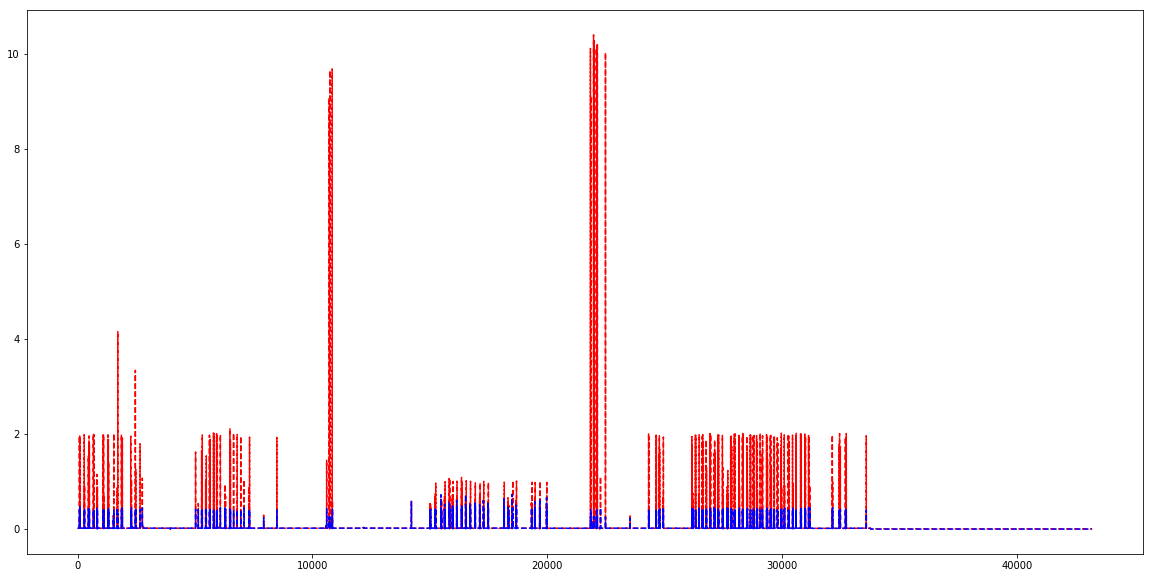

(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/200
65803/65803 [==============================] - 19s 295us/step - loss: 1.6091e-05
Epoch 2/200
65803/65803 [==============================] - 17s 264us/step - loss: 1.0273e-05
Epoch 3/200
65803/65803 [==============================] - 20s 300us/step - loss: 9.3767e-06
Epoch 4/200
65803/65803 [==============================] - 18s 271us/step - loss: 9.0178e-06
Saving model


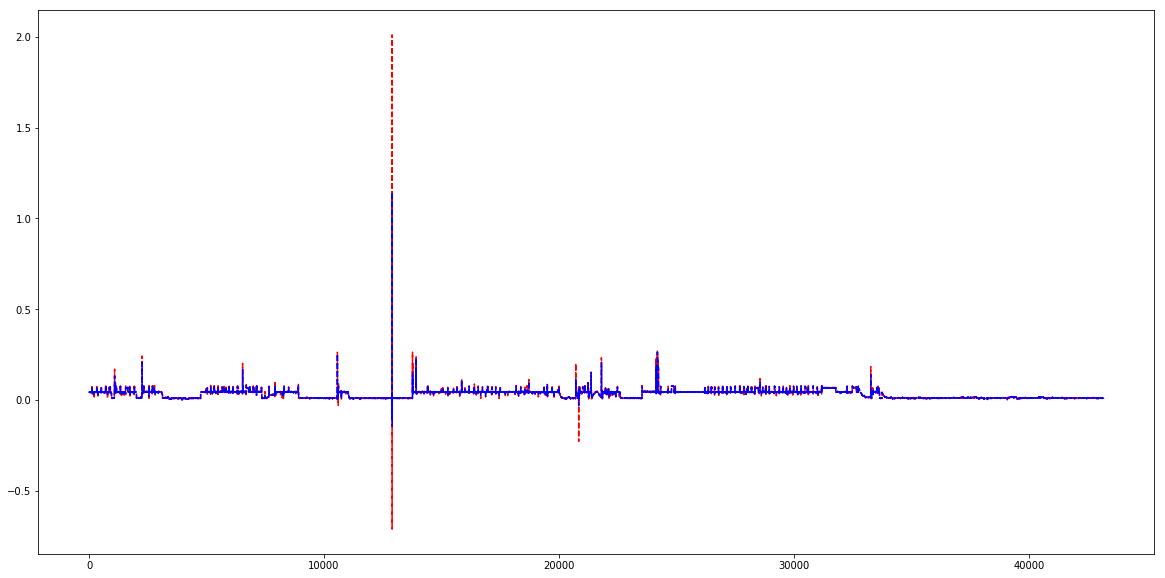

In [11]:
for col in num_cols:
    columnwise_forecast(col)


In [12]:
for k in prediction_store:
    
    yhat = prediction_store[k][1]
    tst_y = prediction_store[k][0]
    residual = np.subtract(yhat.reshape(-1),tst_y)
    print(k ," ----------------------> ")
    print("Min ",np.min(residual)," Max ",np.max(residual)," Mean ",np.mean(residual)," Std ",np.std(residual))
    
    # Outside of mean
    cur_indices = np.where( (residual > np.mean(residual)) | (residual < np.mean(residual)) )[0]
    cur_indices += n_steps
    print("Outside of mean :",Counter(test_labels[cur_indices]))
    
    # Oustise of 1-std dev
    cur_indices = np.where( (residual > (np.mean(residual)+np.std(residual))) | (residual < (np.mean(residual)-np.std(residual))) )[0]
    cur_indices += n_steps
    print("Outside of 1 std-dev :",Counter(test_labels[cur_indices]))
    
    

PI552051.642  ----------------------> 
Min  -1.2282906621694563  Max  0.8689493387937546  Mean  -0.00072025986794628  Std  0.012910314725982024
Outside of mean : Counter({0: 42963, 2: 189, 1: 43})
Outside of 1 std-dev : Counter({0: 230})
PI552051.641  ----------------------> 
Min  -0.07514286239165813  Max  0.05488577485084534  Mean  0.00028949410802539386  Std  0.0011322180571227325
Outside of mean : Counter({0: 42963, 2: 189, 1: 43})
Outside of 1 std-dev : Counter({0: 341})
VI552051.748  ----------------------> 
Min  -19.5906915217638  Max  6.101314216852188  Mean  -0.012265767037899547  Std  0.30366819178468435
Outside of mean : Counter({0: 42963, 2: 189, 1: 43})
Outside of 1 std-dev : Counter({0: 1237})
PI552051.645  ----------------------> 
Min  -1.2460180670022964  Max  0.9566472172737122  Mean  0.0006824475174725775  Std  0.007892834721532965
Outside of mean : Counter({0: 42963, 2: 189, 1: 43})
Outside of 1 std-dev : Counter({0: 14})
SIC552051.801_SP  ----------------------> 
Mi

In [ ]:
print(yhat.shape,tst_y.shape)
residual = np.subtract(yhat.reshape(-1),tst_y)

In [ ]:
print(np.min(residual),np.max(residual),np.mean(residual),np.std(residual))

In [ ]:
cur_indices = np.where( (residual > np.mean(residual)) | (residual < np.mean(residual)) )[0]
# these labels are shorter than actual labels by 6 units (6 <= n_steps)
cur_indices += n_steps
print(Counter(test_labels[cur_indices]))

In [ ]:
print(len(residual),len(test_labels))

In [ ]:
cur_indices = np.where(residual > (np.mean(residual)+np.std(residual)))[0]
# these labels are shorter than actual labels by 6 units (6 <= n_steps)
cur_indices += n_steps
print(Counter(test_labels[cur_indices]))

In [ ]:
cur_indices = np.where(residual < (np.mean(residual)-np.std(residual)))[0]
# these labels are shorter than actual labels by 6 units (6 <= n_steps)
cur_indices += n_steps
print(Counter(test_labels[cur_indices]))

In [ ]:
cur_indices = np.where( (residual > np.mean(residual)) | (residual < np.mean(residual)) )[0]
# these labels are shorter than actual labels by 6 units (6 <= n_steps)
cur_indices += n_steps
print(Counter(test_labels[cur_indices]))